<a href="https://colab.research.google.com/github/nsp24/CityMap-Capstone/blob/master/CityBattleFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is an implementation of the Final Capstone Project, titled as 
# _"The Battle of two cities - New York City vs London"_

> ### Importing the libraries

In [110]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as BSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install geocoder
import geocoder # import geocoder

import seaborn as sns
import matplotlib.pyplot as plt

### Fetching the Geolocation details (Latitudes, Longitudes) of New York City and London

In [0]:
def get_geolocation(address):
  loc = Nominatim().geocode(address)
  geolocation = dict()
  geolocation['latitude'] = loc.latitude
  geolocation['longitude'] = loc.longitude
  return geolocation


In [112]:
"""
Using Nominatim from geopy.geocoders to fetch GeoLocation data on the basis of 
Location string
"""
nyc_loc = get_geolocation('New York City, NY')
nyc_geodata = dict()
nyc_geodata['City'] = 'NYC'
nyc_geodata['Latitude'] = nyc_loc['latitude']
nyc_geodata['Longitude'] = nyc_loc['longitude']

london_loc = get_geolocation('London, England')
london_geodata = dict()
london_geodata['City'] = 'London'
london_geodata['Latitude'] = london_loc['latitude']
london_geodata['Longitude'] = london_loc['longitude']

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


### Using _Foursquare_ Location API to fetch Nearby Locations

> Initializing the basic Foursquare API parameters and Fetching Nearby Venues in the neighborhood
*Please apply your own FourSquare API Credentials here:*

In [0]:
CLIENT_ID = '*****'
CLIENT_SECRET = '*****'
VERSION = '20181026'
LIMIT = 200

In [0]:
def getNearbyVenues(names, lat, lng, radius=500):

  venues_list=[]
#   for name, lat, lng in zip(names, latitudes, longitudes):
  name = names.split(',')[0]
#   print(name)

  # create the API request URL
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      lat, 
      lng, 
      radius, 
      LIMIT)

  # make the GET request
  results = requests.get(url).json()["response"]['groups'][0]['items']
#   print(results)

  # return only relevant information for each nearby venue
  venues_list.append([(

      v['venue']['name'], 
      str(v['venue']['location']['lat']), 
      str(v['venue']['location']['lng']),  
      v['venue']['categories'][0]['name']) for v in results])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = [
                'Venue', 
                'Latitude', 
                'Longitude', 
                'Venue Category']

  return(nearby_venues)

> Fetching Data for NYC and London:

In [0]:
nyc_venues = getNearbyVenues(names=nyc_geodata['City'], lat=nyc_geodata['Latitude'], lng=nyc_geodata['Longitude'])
london_venues = getNearbyVenues(names=london_geodata['City'], lat=london_geodata['Latitude'], lng=london_geodata['Longitude'])

### 1. Grouping the above data on the basis of Venue Categories

In [119]:
nyc_geoloc_groups = (nyc_venues.groupby('Venue Category').apply(lambda x: [i for i in map(lambda p, q: (p,q), x.Latitude, x.Longitude)]).reset_index())
nyc_geoloc_groups.rename(columns={0: 'Coordinates_NYC'}, inplace=True)
print(nyc_geoloc_groups.head(3))

london_geoloc_groups = (london_venues.groupby('Venue Category').apply(lambda y: [i for i in map(lambda p, q: (p,q), y.Latitude, y.Longitude)]).reset_index())
london_geoloc_groups.rename(columns={0: 'Coordinates_London'}, inplace=True)
print(london_geoloc_groups.head(3))

        Venue Category                             Coordinates_NYC
0  American Restaurant  [(40.731155872068506, -73.98872764725327)]
1  Arts & Crafts Store  [(40.729961572238864, -73.98509847052101)]
2     Asian Restaurant  [(40.731718325211304, -73.98555396792241)]
       Venue Category                                 Coordinates_London
0   Accessories Store         [(51.511062857452046, -0.126267671585083)]
1  African Restaurant        [(51.51088902484121, -0.12700505770054704)]
2         Art Gallery  [(51.50943806358441, -0.1280324346985737), (51...


### 2. Merging the geolocation data of NYC for each row of the grouped data

In [120]:
nyc_venue_catg_grouped = nyc_venues.groupby('Venue Category').count().reset_index()
nyc_venue_groups = (nyc_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
nyc_venue_grouped = (nyc_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

nyc_venue_grouped.rename(columns={'Venue': 'Count_NYC'}, inplace=True)
nyc_venue_groups.rename(columns={0: 'Venues_NYC'}, inplace=True)

nyc_count_venues = pd.merge(nyc_venue_groups, nyc_venue_grouped, on="Venue Category", how="inner")
# print(nyc_merged_venues.sort_values('Count_NYC', ascending=False).head(5))

nyc_count_data = pd.merge(nyc_count_venues, nyc_geoloc_groups, on="Venue Category", how="inner")
nyc_count_data
# print(list(nyc_venue_groups.loc[5]))

,Venue Category,Venues_NYC,Count_NYC,Coordinates_NYC
0,American Restaurant,The Smith,1,"[(40.731155872068506, -73.98872764725327)]"
1,Arts & Crafts Store,Casey Rubber Stamp,1,"[(40.729961572238864, -73.98509847052101)]"
2,Asian Restaurant,Momofuku Ssäm Bar,1,"[(40.731718325211304, -73.98555396792241)]"
3,BBQ Joint,Mighty Quinn's BBQ,1,"[(40.7275189451569, -73.98867130279541)]"
4,Bagel Shop,Tompkins Square Bagels,1,"[(40.73078120066792, -73.98602706997711)]"
5,Bakery,Veniero’s Pasticceria & Caffe,1,"[(40.72956613527381, -73.98443484606442)]"
6,Bar,"The Belfry,Ferns",2,"[(40.73286245412899, -73.98630004553797), (40...."
7,Beer Garden,Milk & Hops,1,"[(40.73140685915533, -73.99174677771859)]"
8,Bookstore,Strand Bookstore,1,"[(40.73320178975766, -73.99096009548717)]"
9,Burger Joint,Shake Shack,1,"[(40.72999845323382, -73.9896956893842)]"


### 3. Merging the geolocation data of London for each row of the grouped data

In [121]:
london_venue_catg_grouped = london_venues.groupby('Venue Category').count().reset_index()
london_venue_groups = (london_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
london_venue_grouped = (london_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

london_venue_grouped.rename(columns={'Venue': 'Count_London'}, inplace=True)
london_venue_groups.rename(columns={0: 'Venues_London'}, inplace=True)

london_count_venues = pd.merge(london_venue_groups, london_venue_grouped, on="Venue Category", how="inner")
# print((london_venue_groups.loc[27])[1].split(','))

london_count_data = pd.merge(london_count_venues, london_geoloc_groups, on="Venue Category", how="inner")
london_count_data
# print(london_merged_venues.sort_values('Count_London', ascending=False).head(5))

,Venue Category,Venues_London,Count_London,Coordinates_London
0,Accessories Store,Laird Hats Caps,1,"[(51.511062857452046, -0.126267671585083)]"
1,African Restaurant,Koshari Street,1,"[(51.51088902484121, -0.12700505770054704)]"
2,Art Gallery,"National Portrait Gallery,Institute of Contemp...",3,"[(51.50943806358441, -0.1280324346985737), (51..."
3,Art Museum,National Gallery,1,"[(51.50887601013219, -0.1284778118133545)]"
4,Arts & Crafts Store,Cass Art,1,"[(51.51009713987883, -0.12832854321880532)]"
5,Bakery,Ole & Steen,1,"[(51.509219114319954, -0.1325971590898062)]"
6,Bar,The London Beer House,1,"[(51.50821434015014, -0.13257835254245434)]"
7,Bookstore,"Waterstones,Watkins Books",2,"[(51.50764972496243, -0.12712953878194402), (5..."
8,Boutique,Dover Street Market,1,"[(51.508995574874795, -0.13212434502786355)]"
9,Burger Joint,"Five Guys,Byron",2,"[(51.50853250848257, -0.1244745041598511), (51..."


### 4. Combining the geolocation data of NYC and London for each row of the grouped data

In [122]:
combined_count_data = pd.merge(nyc_count_data, london_count_data, on="Venue Category", how="inner")
combined_count_data

,Venue Category,Venues_NYC,Count_NYC,Coordinates_NYC,Venues_London,Count_London,Coordinates_London
0,Arts & Crafts Store,Casey Rubber Stamp,1,"[(40.729961572238864, -73.98509847052101)]",Cass Art,1,"[(51.51009713987883, -0.12832854321880532)]"
1,Bakery,Veniero’s Pasticceria & Caffe,1,"[(40.72956613527381, -73.98443484606442)]",Ole & Steen,1,"[(51.509219114319954, -0.1325971590898062)]"
2,Bar,"The Belfry,Ferns",2,"[(40.73286245412899, -73.98630004553797), (40....",The London Beer House,1,"[(51.50821434015014, -0.13257835254245434)]"
3,Bookstore,Strand Bookstore,1,"[(40.73320178975766, -73.99096009548717)]","Waterstones,Watkins Books",2,"[(51.50764972496243, -0.12712953878194402), (5..."
4,Burger Joint,Shake Shack,1,"[(40.72999845323382, -73.9896956893842)]","Five Guys,Byron",2,"[(51.50853250848257, -0.1244745041598511), (51..."
5,Café,"Mudspot,Saltwater Coffee",2,"[(40.7290704479652, -73.98681104426099), (40.7...","Café In The Crypt,Portrait Restaurant",2,"[(51.50896230356763, -0.12672904352900202), (5..."
6,Coffee Shop,"Hi-Collar - ハイカラ (Hi-Collar),Third Rail Coffee...",4,"[(40.729449019976, -73.98591848402724), (40.72...","Notes Music & Coffee,The Espresso Room",2,"[(51.509696003098284, -0.12698537841552573), (..."
7,Greek Restaurant,Taverna Kyclades,1,"[(40.73117860451496, -73.98271881421127)]",Milos,1,"[(51.50811719446084, -0.13334124484466278)]"
8,Ice Cream Shop,"Sundaes and Cones,Fresco Gelateria,Snowdays Sh...",6,"[(40.7309885617057, -73.98939013481139), (40.7...","Amorino,La Gelatiera,Milk Train,Amorino",4,"[(51.51042726621419, -0.12840081492921637), (5..."
9,Japanese Restaurant,"Kotobuki,Ikinari Steak,Taishu-Izakaya Kenka,Oh...",4,"[(40.73103729924171, -73.98886456133741), (40....","Japan Centre,Machiya",2,"[(51.509760861810946, -0.13127297164342394), (..."


### 5. Performing Clustering on the aforeformed data using k-Means Clustering algorithm

In [123]:
k_cluster_num = 5
columns = ['NYC_Venue_Count', 'London_Venue_Count']
data_temp = {'NYC_Venue_Count': combined_count_data['Count_NYC'], 'London_Venue_Count': combined_count_data['Count_London']}
# print(london_venue_grouped['Venue'])
data_temp_df = pd.DataFrame(data_temp, columns=columns)
print(data_temp_df)
k_means_count = KMeans(n_clusters=k_cluster_num, random_state=0).fit(data_temp_df)
print(k_means_count.labels_)

    NYC_Venue_Count  London_Venue_Count
0                 1                   1
1                 1                   1
2                 2                   1
3                 1                   2
4                 1                   2
5                 2                   2
6                 4                   2
7                 1                   1
8                 6                   4
9                 4                   2
10                2                   1
11                4                   1
12                1                   4
13                2                   2
14                1                   3
15                1                   1
16                1                   1
17                2                   2
18                1                   2
19                1                   1
[1 1 1 4 4 4 3 1 2 3 1 3 0 4 0 1 1 4 4 1]


### 6. Merging the Cluster labels with the Count data

In [124]:
# Creating a DataFrame with both Cluster-values and top-10 venues of each neighborhood
count_combined = combined_count_data
count_combined['Cluster Labels'] = k_means_count.labels_
print(count_combined.head(3))
# count_combined = count_combined.join(neighbourhoods_sorted.set_index('Neighborhood'), on='Neighborhood')

        Venue Category                     Venues_NYC  Count_NYC  \
0  Arts & Crafts Store             Casey Rubber Stamp          1   
1               Bakery  Veniero’s Pasticceria & Caffe          1   
2                  Bar               The Belfry,Ferns          2   

                                     Coordinates_NYC          Venues_London  \
0         [(40.729961572238864, -73.98509847052101)]               Cass Art   
1          [(40.72956613527381, -73.98443484606442)]            Ole & Steen   
2  [(40.73286245412899, -73.98630004553797), (40....  The London Beer House   

   Count_London                           Coordinates_London  Cluster Labels  
0             1  [(51.51009713987883, -0.12832854321880532)]               1  
1             1  [(51.509219114319954, -0.1325971590898062)]               1  
2             1  [(51.50821434015014, -0.13257835254245434)]               1  


---
### 7. Grouping and combining each returned venue and location of NYC

In [0]:
# onehot-encoding the venues-data:
nyc_venues_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix='', prefix_sep='')
# print(nyc_venues_onehot)

nyc_venues_onehot['Venue Category'] = nyc_venues['Venue Category']
# nyc_venues_onehot
nyc_venues_grouped_mean = nyc_venues_onehot.groupby('Venue Category').mean().reset_index()

nyc_mean_data = pd.merge(nyc_venues_grouped_mean, nyc_geoloc_groups, on="Venue Category", how="inner")

nyc_venues_mean_temp = nyc_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_nyc = KMeans(n_clusters=k_cluster_num, random_state=0).fit(nyc_venues_mean_temp)
nyc_mean_merged = nyc_venues_grouped_mean
nyc_mean_merged['Cluster Labels'] = k_means_avg_nyc.labels_
nyc_mean_merged = pd.merge(nyc_mean_merged[['Venue Category', 'Cluster Labels']], nyc_venues_onehot, on='Venue Category', how='inner')
nyc_mean_merged = pd.merge(nyc_mean_merged, nyc_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
nyc_mean_merged.drop_duplicates(inplace=True)

---
### 8.Grouping and combining each returned venue and location of London

In [0]:
# onehot-encoding the venues-data:
london_venues_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix='', prefix_sep='')
# print(london_venues_onehot)

london_venues_onehot['Venue Category'] = london_venues['Venue Category']
london_venues_grouped_mean = london_venues_onehot.groupby('Venue Category').mean().reset_index()

london_mean_data = pd.merge(london_venues_grouped_mean, london_geoloc_groups, on="Venue Category", how="inner")

london_venues_mean_temp = london_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_london = KMeans(n_clusters=k_cluster_num, random_state=0).fit(london_venues_mean_temp)
london_mean_merged = london_venues_grouped_mean
london_mean_merged['Cluster Labels'] = k_means_avg_london.labels_
london_mean_merged = pd.merge(london_mean_merged[['Venue Category', 'Cluster Labels']], london_venues_onehot, on='Venue Category', how='inner')
# london_mean_merged[['Venue Category', 'Cluster Labels']]
london_mean_merged = pd.merge(london_mean_merged, london_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
london_mean_merged.drop_duplicates(inplace=True)

### 9. Visualizing all the returned venues of NYC and London

#### Creating a function to visualize _all the venues_ of NYC and London using Folium Maps

In [0]:
def create_city_map(merged_data, geoloc_data, common_data):
  base_lat = geoloc_data['Latitude']
  base_lng = geoloc_data['Longitude']
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=16)

  # set color scheme for the clusters
  x = np.arange(k_cluster_num)
  ys = [i+x+(i*x)**2 for i in range(k_cluster_num)]
  colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
  rainbow = [colors.rgb2hex(i) for i in colors_array]

  # add markers to the map
  markers_colors = []
  for lat, lon, poi, cluster, categ in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Venue'], merged_data['Cluster Labels'], merged_data['Venue Category']):
    label = folium.Popup('{} ({}) - Cluster {}'.format(str(poi), categ, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

  return map_clusters


#### Map of Popular Venues in NewYork City

In [128]:
nyc_overall_map = create_city_map(nyc_mean_merged, nyc_geodata, count_combined)
nyc_overall_map

#### Map of Popular Venues in London

In [129]:
london_overall_map = create_city_map(london_mean_merged, london_geodata, count_combined)
london_overall_map

### 10. Creating a function to display each venue from the combined count data using Folium Maps

In [0]:
""" 
Creating map of Cities's Neighborhood using Folium
"""

# defining the Folium Map in a function
def create_map(city_data, geoloc_data):
  base_lat = float(geoloc_data['Latitude'])
  base_lng = float(geoloc_data['Longitude'])
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=16)

  # set color scheme for the clusters

  rainbow = ['#F84583', '#4868F7', '#53DEE8', '#00F950', '#F9FA20']
  geodata_param = city_data['Coordinates_{}'.format(geoloc_data['City'])]
  venue_param = city_data['Venues_{}'.format(geoloc_data['City'])]

  # add markers to the map
  markers_colors = []

  for geo_data, venues, cluster, categ in zip(geodata_param, venue_param, city_data['Cluster Labels'], city_data['Venue Category']):
#     print('{}: [{}] - cluster {}'.format(venues, geo_data, cluster))
    for geoloc, poi in zip(geo_data, venues.split(',')):
#       print('{1}: {0}'.format(geoloc, poi))
      label = folium.Popup(str(poi) + ' ( {} ) - Cluster {}'.format(categ, str(cluster)), parse_html=True)
      folium.CircleMarker(
          [float(geoloc[0]), float(geoloc[1])],
          radius=5,
          popup=label,
          color=rainbow[cluster-1],
          fill=True,
          fill_color=rainbow[cluster-1],
          fill_opacity=1).add_to(map_clusters)
  return map_clusters

--- 
### Displaying New York City Venues

In [131]:
nyc_cluster_map = create_map(count_combined, nyc_geodata)
nyc_cluster_map

## Cluster Analysis for NYC

#### First Cluster

In [132]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
nyc_first_cluster = create_map(first_cluster, nyc_geodata)
nyc_first_cluster

2


#### Second Cluster

In [133]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(second_cluster))
nyc_second_cluster = create_map(second_cluster, nyc_geodata)
nyc_second_cluster

8


#### Third Cluster

In [134]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(third_cluster))
nyc_third_cluster = create_map(third_cluster, nyc_geodata)
nyc_third_cluster

1


#### Fourth Cluster

In [135]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(fourth_cluster))
nyc_fourth_cluster = create_map(fourth_cluster, nyc_geodata)
nyc_fourth_cluster

3


#### Fifth Cluster

In [136]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
nyc_fifth_cluster = create_map(fifth_cluster, nyc_geodata)
nyc_fifth_cluster

6


---
### Displaying London Venues

In [137]:
london_cluster_map = create_map(count_combined, london_geodata)
london_cluster_map

## Analysing Clusters of London

#### First Cluster

In [138]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
london_first_cluster = create_map(first_cluster, london_geodata)
london_first_cluster

2


#### Second Cluster

In [139]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(second_cluster.shape[0])
london_second_cluster = create_map(second_cluster, london_geodata)
london_second_cluster

8


#### Third Cluster

In [140]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(third_cluster.shape[0])
london_third_cluster = create_map(third_cluster, london_geodata)
london_third_cluster

1


#### Fourth Cluster

In [141]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fourth_cluster.shape[0])
london_fourth_cluster = create_map(fourth_cluster, london_geodata)
london_fourth_cluster

3


#### Fifth Cluster

In [142]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
london_fifth_cluster = create_map(fifth_cluster, london_geodata)
london_fifth_cluster

6


---
## Visualizations

### 1. Bar charts to analyze frequency of occurrences of venue categories in both the cities

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


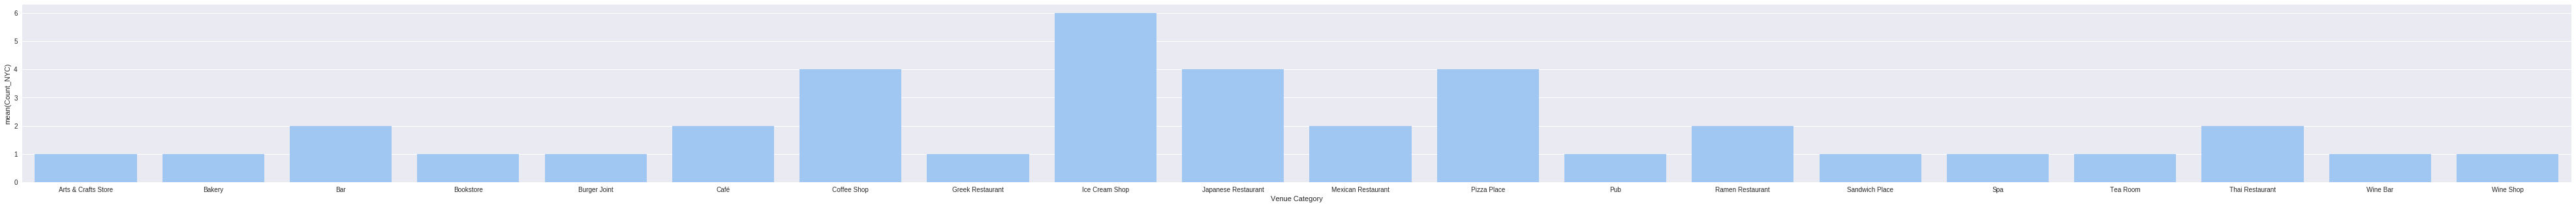

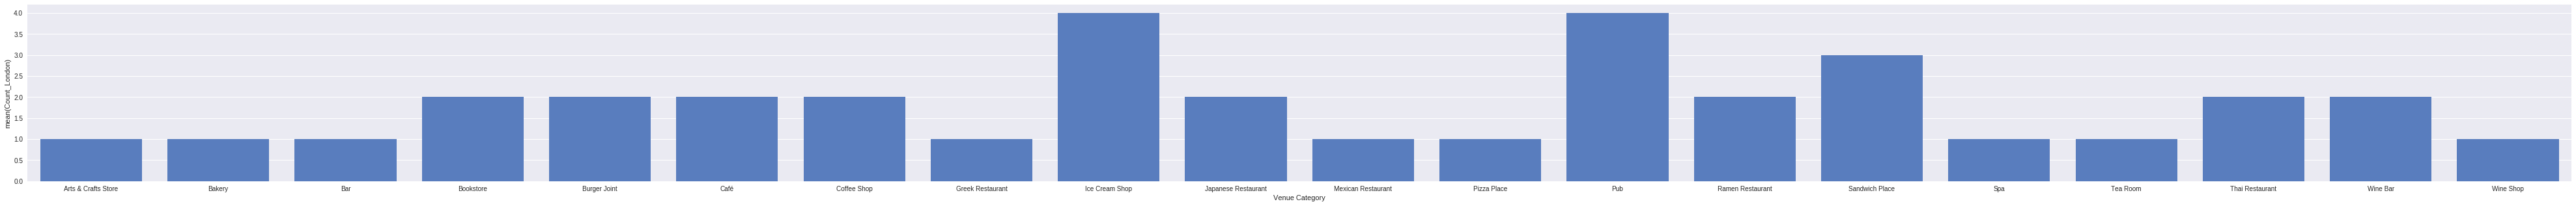

In [55]:
plt.figure(figsize=(70,5))
sns.set_color_codes("pastel")
sns.barplot(x='Venue Category', y='Count_NYC', data=count_combined, color='b', label='New York City', )
# nyc_plot.set_xticklabels(labels=list(count_combined['Venue Category']), rotation=40)
# london_plot.set_xticklabels(labels=list(count_combined['Venue Category']), rotation=40)

plt.figure(figsize=(70,5))
sns.set_color_codes("muted")
sns.barplot(x='Venue Category', y='Count_London', data=count_combined, color='b', label='London City')

### 2. Constructing a Strip plot for a cumulative visualization of occurrence-frequencies

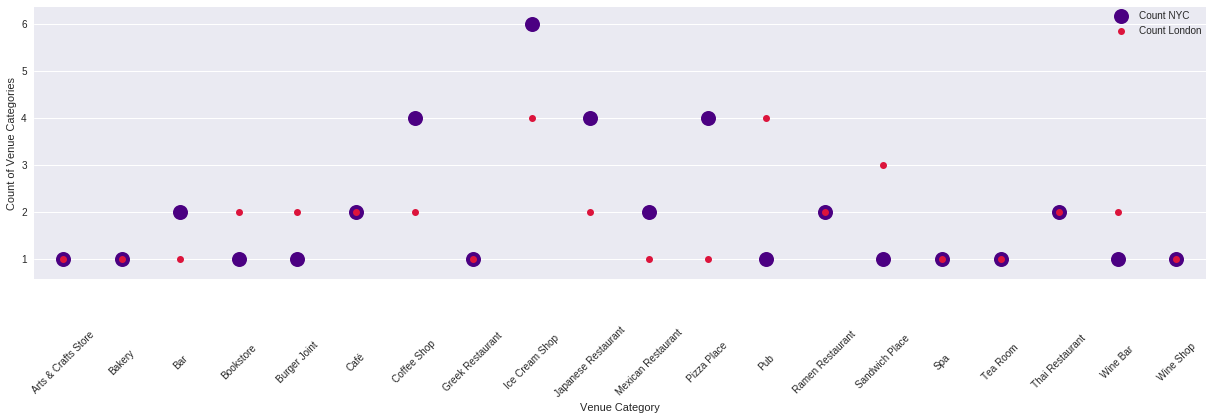

In [54]:
handles = list()
labels = list()
plt.figure(figsize=(21, 5))

sns.set_color_codes("pastel")

ax = sns.stripplot(x='Venue Category', y='Count_NYC', data=count_combined,palette=['indigo'],size=15, label='Count NYC')

handle, label = ax.get_legend_handles_labels()
handles.append(handle[0])
labels.append(label[0])

ax.set_xticklabels(list(count_combined['Venue Category']), rotation = 45, va="center", position=(0,-0.28))

sns.set_color_codes("muted")

ax1 = sns.stripplot(x='Venue Category', y='Count_London', data=count_combined, palette=['crimson'], size=7, label='Count London')

handle1, label1 = ax1.get_legend_handles_labels()

handles.append(handle1[len(handle)+1])
labels.append(label1[len(label)+1])

plt.ylabel('Count of Venue Categories')

plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)